<a href="https://colab.research.google.com/github/soutsios/bert-sentencepiece/blob/master/final_bert_long_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [0]:
import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

In [0]:
import os
os.listdir('.')

['.config', 'consumer_complaints.csv', 'sample_data']

# Loading The Data

In [0]:
train_raw = pd.read_csv('consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074.0
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080.0
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473.0
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326.0
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067.0


In [0]:
train_raw.shape

(221491, 18)

# Preprocessing Data

Select non null:

In [0]:
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(6094, 18)

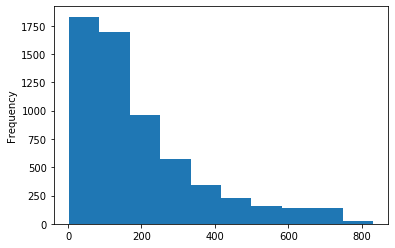

In [0]:
train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split())).plot(kind='hist')

In [0]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))
train_raw.describe()

,complaint_id,len_txt
count,6.094000e+03,6094.000000
mean,1.330153e+06,193.447653
std,2.562707e+04,166.860882
min,1.290181e+06,2.000000
25%,1.308488e+06,73.000000
50%,1.324314e+06,137.000000
75%,1.350820e+06,259.000000
max,1.394288e+06,831.000000


In [0]:
train_raw.shape

(6094, 19)

Select only the row with number of words greater than 250:

In [0]:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(1614, 19)

In [0]:
train_raw = train_raw[['consumer_complaint_narrative', 'product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


Group similar products

In [0]:
train_raw.at[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [0]:
for l in np.unique(train_raw['product']):
  print(l)

Bank account or service
Consumer Loan
Credit card or prepaid card
Credit reporting, credit repair services, or other personal consumer reports
Debt collection
Money transfers
Mortgage
Other financial service
Payday loan, title loan, or personal loan
Student loan


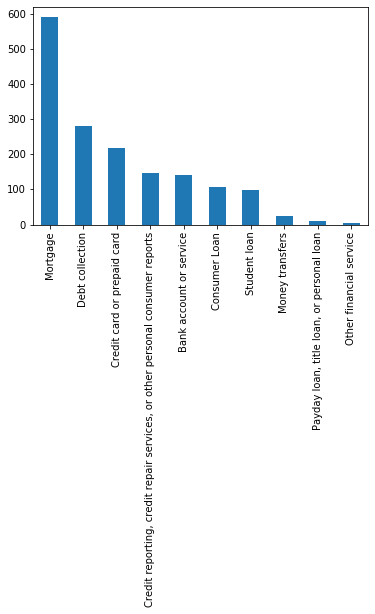

In [0]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [0]:
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [0]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [0]:
len(np.unique(train_raw['label']))

10

In [0]:
train = train_raw.copy()

In [0]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
404,We have a loan through B of A ( Bank of Americ...,6
247,I have complained to Lender Live NUMEROUS time...,6
916,Suntrust Bank advertised a bank account openin...,0
1398,"Dear Madam or Sir, this is a complaint in rega...",3
1407,The mortgage company does n't pay homeowner 's...,6


Clean the text columns

In [0]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [0]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
404,We have a loan through B of A Bank of America ...,6
247,I have complained to Lender Live NUMEROUS time...,6
916,Suntrust Bank advertised a bank account openin...,0
1398,Dear Madam or Sir this is a complaint in regar...,3
1407,The mortgage company does nt pay homeowner s i...,6


In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label
935,This is the e mail that I received I want to k...,4
601,The US Air ways and XXXX XXXX merger has creat...,2
1307,This company sent a negative information as re...,4
1420,I first received a type of advertisement from ...,1
1386,I was approved for a Making Homes Affordable m...,6


In [0]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,This is the e mail that I received I want to k...,4
1,The US Air ways and XXXX XXXX merger has creat...,2


In [0]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,We purchased our home in XX XX XXXX We were no...,6
1,Back a XXXX ago I had to take my XXXX yr old s...,2


In [0]:
val.shape, train.shape

((323, 2), (1291, 2))

In [0]:
#Installing BERT module
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.3MB/s 


In [0]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# Setting The Output Directory for BERT

In [0]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


In [0]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (1291, 2)
Validation Set Shape : (323, 2)


In [0]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [0]:
def get_split(text1):
  a=150
  b=200
  l_total = []
  l_parcial = []
  if len(text1.split())//a >0:
    n = len(text1.split())//a
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:b]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*a:w*a + b]
      l_total.append(" ".join(l_parcial))
  return l_total

In [0]:
len(text.split())

24

In [0]:
text = 'I paid Greentree Servicing LLC XXXX payments in XXXX and XXXX after my loan was up because a rep with their company told me'

In [0]:
get_split(text)

['I paid Greentree Servicing LLC XXXX payments in XXXX',
 'payments in XXXX and XXXX after my loan was',
 'my loan was up because a rep with their',
 'rep with their company told me']

In [0]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,This is the e mail that I received I want to k...,4,[This is the e mail that I received I want to ...
1,The US Air ways and XXXX XXXX merger has creat...,2,[The US Air ways and XXXX XXXX merger has crea...
2,This company sent a negative information as re...,4,[This company sent a negative information as r...
3,I first received a type of advertisement from ...,1,[I first received a type of advertisement from...
4,I was approved for a Making Homes Affordable m...,6,[I was approved for a Making Homes Affordable ...


In [0]:
train['text_split'][0]

['I paid Greentree Servicing LLC XXXX payments in XXXX and XXXX after my loan was up because a rep with their company told me if I made the payments I would be fine nothing would happen Then they mailed a paper dated XXXX XXXX 15 saying I owed a balloon payment owing them 2400 00 and then they turned around a day later I received a certified letter I signed for on XX XX XXXX saying that I owed 3000 00 and that letter was dated XXXX day later on XXXX XXXX 2015 so it went up 570 00 plus a 5 00 late fee was added into that how I dont know Then on XXXX at XXXX I spoke with XXXX XXXX and we cam to an agreement settlement that if I paid them 6100 00 that my account would be paid off in full and I told her I wanted documentation that it would be and she refused to send me anything So finally XXXX XXXX XXXX sent a letter saying if I sent a certified check by to the XXXX it was paid in full I asked XXXX XXXX if I could deduct the checks from XXXX',
 'I wanted documentation that it would be and 

In [0]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,We purchased our home in XX XX XXXX We were no...,6,[We purchased our home in XX XX XXXX We were n...
1,Back a XXXX ago I had to take my XXXX yr old s...,2,[Back a XXXX ago I had to take my XXXX yr old ...


In [0]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(2972, 2972, 2972)

In [0]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(739, 739, 739)

The final dataset for training:

In [0]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,This is the e mail that I received I want to k...,4
1,that I shall call you and notify you about thi...,4
2,The US Air ways and XXXX XXXX merger has creat...,2
3,been with Barclays XXXX and how many of the ru...,2
4,this change essential It did nt appear to be B...,2


In [0]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,We purchased our home in XX XX XXXX We were no...,6
1,claim and am being stonewalled on all sides th...,6
2,Back a XXXX ago I had to take my XXXX yr old s...,2
3,because of the pain he was in It was a very st...,2
4,To Whom It May concern I had attended XXXX XXX...,9


# BERT: Data Preprocessing 

Process the data for BERT

In [0]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [0]:
train_InputExamples

0        <bert.run_classifier.InputExample object at 0x...
1        <bert.run_classifier.InputExample object at 0x...
2        <bert.run_classifier.InputExample object at 0x...
3        <bert.run_classifier.InputExample object at 0x...
4        <bert.run_classifier.InputExample object at 0x...
                               ...                        
31674    <bert.run_classifier.InputExample object at 0x...
31675    <bert.run_classifier.InputExample object at 0x...
31676    <bert.run_classifier.InputExample object at 0x...
31677    <bert.run_classifier.InputExample object at 0x...
31678    <bert.run_classifier.InputExample object at 0x...
Length: 31679, dtype: object

In [0]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  This is the e mail that I received I want to know if this is legit Original Creditor Advance America Cash Advance Subject Unpaid debt of Advance AmericaFile Number XXXX XXXX ClientWe regret to inform you that due to your unpaid debt amount of 570 00 to Advance America Cash Advance from today we have passed your case to court You are now to be contacted by official court attorneys who will notify you of the hearing date Therefore you will be served a subpoena to appear at court where you can present your defense We still have not received any payment or answer from you Therefore we regret to inform you that if we do not obtain the payment of 570 00 in full before end of the day we will have no other alternatives but to undertake court actions against you so before something goes wrong I thought that I shall call you and notify you about this matter But as I was not able to reach you so I am sending you a 

# BERT: Loading the pre-trained model

In [0]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
len(tokenizer.vocab.keys())

30522

In [0]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['this', 'is', 'the', 'e', 'mail', 'that', 'i', 'received', 'i', 'want', 'to', 'know', 'if', 'this', 'is', 'leg', '##it', 'original', 'credit', '##or', 'advance', 'america', 'cash', 'advance', 'subject', 'unpaid', 'debt', 'of', 'advance', 'america', '##fi', '##le', 'number', 'xx', '##xx', 'xx', '##xx', 'client', '##we', 'regret', 'to', 'inform', 'you', 'that', 'due', 'to', 'your', 'unpaid', 'debt', 'amount', 'of', '570', '00', 'to', 'advance', 'america', 'cash', 'advance', 'from', 'today', 'we', 'have', 'passed', 'your', 'case', 'to', 'court', 'you', 'are', 'now', 'to', 'be', 'contacted', 'by', 'official', 'court', 'attorneys', 'who', 'will', 'not', '##ify', 'you', 'of', 'the', 'hearing', 'date', 'therefore', 'you', 'will', 'be', 'served', 'a', 'sub', '##po', '##ena', 'to', 'appear', 'at', 'court', 'where', 'you', 'can', 'present', 'your', 'defense', 'we', 'still', 'have', 'not', 'received', 'any', 'payment', 'or', 'answer', 'from', 'you', 'therefore', 'we', 'regret', 'to', 'inform', '

In [0]:
MAX_SEQ_LENGTH = 200

In [0]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 2972


INFO:tensorflow:Writing example 0 of 2972


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this is the e mail that i received i want to know if this is leg ##it original credit ##or advance america cash advance subject unpaid debt of advance america ##fi ##le number xx ##xx xx ##xx client ##we regret to inform you that due to your unpaid debt amount of 570 00 to advance america cash advance from today we have passed your case to court you are now to be contacted by official court attorneys who will not ##ify you of the hearing date therefore you will be served a sub ##po ##ena to appear at court where you can present your defense we still have not received any payment or answer from you therefore we regret to inform you that if we do not obtain the payment of 570 00 in full before end of the day we will have no other alternatives but to undertake court actions against you so before something goes wrong i thought that i shall call you and not ##ify you about this matter but as i was not able to reach you so i am sending you a final notification e

INFO:tensorflow:tokens: [CLS] this is the e mail that i received i want to know if this is leg ##it original credit ##or advance america cash advance subject unpaid debt of advance america ##fi ##le number xx ##xx xx ##xx client ##we regret to inform you that due to your unpaid debt amount of 570 00 to advance america cash advance from today we have passed your case to court you are now to be contacted by official court attorneys who will not ##ify you of the hearing date therefore you will be served a sub ##po ##ena to appear at court where you can present your defense we still have not received any payment or answer from you therefore we regret to inform you that if we do not obtain the payment of 570 00 in full before end of the day we will have no other alternatives but to undertake court actions against you so before something goes wrong i thought that i shall call you and not ##ify you about this matter but as i was not able to reach you so i am sending you a final notification e

INFO:tensorflow:input_ids: 101 2023 2003 1996 1041 5653 2008 1045 2363 1045 2215 2000 2113 2065 2023 2003 4190 4183 2434 4923 2953 5083 2637 5356 5083 3395 23850 7016 1997 5083 2637 8873 2571 2193 22038 20348 22038 20348 7396 8545 9038 2000 12367 2017 2008 2349 2000 2115 23850 7016 3815 1997 24902 4002 2000 5083 2637 5356 5083 2013 2651 2057 2031 2979 2115 2553 2000 2457 2017 2024 2085 2000 2022 11925 2011 2880 2457 16214 2040 2097 2025 8757 2017 1997 1996 4994 3058 3568 2017 2097 2022 2366 1037 4942 6873 8189 2000 3711 2012 2457 2073 2017 2064 2556 2115 3639 2057 2145 2031 2025 2363 2151 7909 2030 3437 2013 2017 3568 2057 9038 2000 12367 2017 2008 2065 2057 2079 2025 6855 1996 7909 1997 24902 4002 1999 2440 2077 2203 1997 1996 2154 2057 2097 2031 2053 2060 15955 2021 2000 16617 2457 4506 2114 2017 2061 2077 2242 3632 3308 1045 2245 2008 1045 4618 2655 2017 1998 2025 8757 2017 2055 2023 3043 2021 2004 1045 2001 2025 2583 2000 3362 2017 2061 1045 2572 6016 2017 1037 2345 26828 10373 302

INFO:tensorflow:input_ids: 101 2023 2003 1996 1041 5653 2008 1045 2363 1045 2215 2000 2113 2065 2023 2003 4190 4183 2434 4923 2953 5083 2637 5356 5083 3395 23850 7016 1997 5083 2637 8873 2571 2193 22038 20348 22038 20348 7396 8545 9038 2000 12367 2017 2008 2349 2000 2115 23850 7016 3815 1997 24902 4002 2000 5083 2637 5356 5083 2013 2651 2057 2031 2979 2115 2553 2000 2457 2017 2024 2085 2000 2022 11925 2011 2880 2457 16214 2040 2097 2025 8757 2017 1997 1996 4994 3058 3568 2017 2097 2022 2366 1037 4942 6873 8189 2000 3711 2012 2457 2073 2017 2064 2556 2115 3639 2057 2145 2031 2025 2363 2151 7909 2030 3437 2013 2017 3568 2057 9038 2000 12367 2017 2008 2065 2057 2079 2025 6855 1996 7909 1997 24902 4002 1999 2440 2077 2203 1997 1996 2154 2057 2097 2031 2053 2060 15955 2021 2000 16617 2457 4506 2114 2017 2061 2077 2242 3632 3308 1045 2245 2008 1045 4618 2655 2017 1998 2025 8757 2017 2055 2023 3043 2021 2004 1045 2001 2025 2583 2000 3362 2017 2061 1045 2572 6016 2017 1037 2345 26828 10373 302

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] that i shall call you and not ##ify you about this matter but as i was not able to reach you so i am sending you a final notification email ##as we put your social security number into our national checking database system we found that you have been never charged for a fraud activity that s the reason we have decided to give you chance to take care of this issue outside the court without having a negative report on your credit history and social security number we would advise to treat this matter with urgency and we believe you will not ignore this final reminder to save yourself the inc ##on ##ven ##ience of court actions we kindly suggest settling the total amount of debt and additional costs as soon as possible we still trust court actions will not be necessary and look forward to receiving payment by return if you wish to settle the outstanding amount or if you have any questions regarding the current situation please do not hesitate to send us an xx

INFO:tensorflow:tokens: [CLS] that i shall call you and not ##ify you about this matter but as i was not able to reach you so i am sending you a final notification email ##as we put your social security number into our national checking database system we found that you have been never charged for a fraud activity that s the reason we have decided to give you chance to take care of this issue outside the court without having a negative report on your credit history and social security number we would advise to treat this matter with urgency and we believe you will not ignore this final reminder to save yourself the inc ##on ##ven ##ience of court actions we kindly suggest settling the total amount of debt and additional costs as soon as possible we still trust court actions will not be necessary and look forward to receiving payment by return if you wish to settle the outstanding amount or if you have any questions regarding the current situation please do not hesitate to send us an xx

INFO:tensorflow:input_ids: 101 2008 1045 4618 2655 2017 1998 2025 8757 2017 2055 2023 3043 2021 2004 1045 2001 2025 2583 2000 3362 2017 2061 1045 2572 6016 2017 1037 2345 26828 10373 3022 2057 2404 2115 2591 3036 2193 2046 2256 2120 9361 7809 2291 2057 2179 2008 2017 2031 2042 2196 5338 2005 1037 9861 4023 2008 1055 1996 3114 2057 2031 2787 2000 2507 2017 3382 2000 2202 2729 1997 2023 3277 2648 1996 2457 2302 2383 1037 4997 3189 2006 2115 4923 2381 1998 2591 3036 2193 2057 2052 18012 2000 7438 2023 3043 2007 19353 1998 2057 2903 2017 2097 2025 8568 2023 2345 14764 2000 3828 4426 1996 4297 2239 8159 13684 1997 2457 4506 2057 19045 6592 9853 1996 2561 3815 1997 7016 1998 3176 5366 2004 2574 2004 2825 2057 2145 3404 2457 4506 2097 2025 2022 4072 1998 2298 2830 2000 4909 7909 2011 2709 2065 2017 4299 2000 7392 1996 5151 3815 2030 2065 2017 2031 2151 3980 4953 1996 2783 3663 3531 2079 2025 16390 2000 4604 2149 2019 22038 20348 20348 20348 20348 20348 2024 2469 1996 3291 2097 2022 13332 2574

INFO:tensorflow:input_ids: 101 2008 1045 4618 2655 2017 1998 2025 8757 2017 2055 2023 3043 2021 2004 1045 2001 2025 2583 2000 3362 2017 2061 1045 2572 6016 2017 1037 2345 26828 10373 3022 2057 2404 2115 2591 3036 2193 2046 2256 2120 9361 7809 2291 2057 2179 2008 2017 2031 2042 2196 5338 2005 1037 9861 4023 2008 1055 1996 3114 2057 2031 2787 2000 2507 2017 3382 2000 2202 2729 1997 2023 3277 2648 1996 2457 2302 2383 1037 4997 3189 2006 2115 4923 2381 1998 2591 3036 2193 2057 2052 18012 2000 7438 2023 3043 2007 19353 1998 2057 2903 2017 2097 2025 8568 2023 2345 14764 2000 3828 4426 1996 4297 2239 8159 13684 1997 2457 4506 2057 19045 6592 9853 1996 2561 3815 1997 7016 1998 3176 5366 2004 2574 2004 2825 2057 2145 3404 2457 4506 2097 2025 2022 4072 1998 2298 2830 2000 4909 7909 2011 2709 2065 2017 4299 2000 7392 1996 5151 3815 2030 2065 2017 2031 2151 3980 4953 1996 2783 3663 3531 2079 2025 16390 2000 4604 2149 2019 22038 20348 20348 20348 20348 20348 2024 2469 1996 3291 2097 2022 13332 2574

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the us air ways and xx ##xx xx ##xx merger has created many problems for me as a credit card holder i have been issued about xx ##xx different card numbers because of the merger and supposedly there will be at least xx ##xx more at the merger each card number changes the prior account is no longer available and it creates a lot of problems for direct billings that the card holder has and is expected to not ##ify those companies that direct bill with each card change this is not an easy task and who knows what happens to a credit score during this process and changing the credit card is very time consuming both for the card holder and the business and seems to significantly interfere with the time responsibilities and work for each since most account changes need to be made between xx ##xx xx ##xx m f the most annoying change has been with barclay ##s xx ##xx and how many of the rules have changed in terms of cut off time to pay which is now xx ##xx eastern

INFO:tensorflow:tokens: [CLS] the us air ways and xx ##xx xx ##xx merger has created many problems for me as a credit card holder i have been issued about xx ##xx different card numbers because of the merger and supposedly there will be at least xx ##xx more at the merger each card number changes the prior account is no longer available and it creates a lot of problems for direct billings that the card holder has and is expected to not ##ify those companies that direct bill with each card change this is not an easy task and who knows what happens to a credit score during this process and changing the credit card is very time consuming both for the card holder and the business and seems to significantly interfere with the time responsibilities and work for each since most account changes need to be made between xx ##xx xx ##xx m f the most annoying change has been with barclay ##s xx ##xx and how many of the rules have changed in terms of cut off time to pay which is now xx ##xx eastern

INFO:tensorflow:input_ids: 101 1996 2149 2250 3971 1998 22038 20348 22038 20348 7660 2038 2580 2116 3471 2005 2033 2004 1037 4923 4003 9111 1045 2031 2042 3843 2055 22038 20348 2367 4003 3616 2138 1997 1996 7660 1998 10743 2045 2097 2022 2012 2560 22038 20348 2062 2012 1996 7660 2169 4003 2193 3431 1996 3188 4070 2003 2053 2936 2800 1998 2009 9005 1037 2843 1997 3471 2005 3622 26124 2008 1996 4003 9111 2038 1998 2003 3517 2000 2025 8757 2216 3316 2008 3622 3021 2007 2169 4003 2689 2023 2003 2025 2019 3733 4708 1998 2040 4282 2054 6433 2000 1037 4923 3556 2076 2023 2832 1998 5278 1996 4923 4003 2003 2200 2051 15077 2119 2005 1996 4003 9111 1998 1996 2449 1998 3849 2000 6022 15115 2007 1996 2051 10198 1998 2147 2005 2169 2144 2087 4070 3431 2342 2000 2022 2081 2090 22038 20348 22038 20348 1049 1042 1996 2087 15703 2689 2038 2042 2007 23724 2015 22038 20348 1998 2129 2116 1997 1996 3513 2031 2904 1999 3408 1997 3013 2125 2051 2000 3477 2029 2003 2085 22038 20348 2789 1045 2444 1999 2430 2

INFO:tensorflow:input_ids: 101 1996 2149 2250 3971 1998 22038 20348 22038 20348 7660 2038 2580 2116 3471 2005 2033 2004 1037 4923 4003 9111 1045 2031 2042 3843 2055 22038 20348 2367 4003 3616 2138 1997 1996 7660 1998 10743 2045 2097 2022 2012 2560 22038 20348 2062 2012 1996 7660 2169 4003 2193 3431 1996 3188 4070 2003 2053 2936 2800 1998 2009 9005 1037 2843 1997 3471 2005 3622 26124 2008 1996 4003 9111 2038 1998 2003 3517 2000 2025 8757 2216 3316 2008 3622 3021 2007 2169 4003 2689 2023 2003 2025 2019 3733 4708 1998 2040 4282 2054 6433 2000 1037 4923 3556 2076 2023 2832 1998 5278 1996 4923 4003 2003 2200 2051 15077 2119 2005 1996 4003 9111 1998 1996 2449 1998 3849 2000 6022 15115 2007 1996 2051 10198 1998 2147 2005 2169 2144 2087 4070 3431 2342 2000 2022 2081 2090 22038 20348 22038 20348 1049 1042 1996 2087 15703 2689 2038 2042 2007 23724 2015 22038 20348 1998 2129 2116 1997 1996 3513 2031 2904 1999 3408 1997 3013 2125 2051 2000 3477 2029 2003 2085 22038 20348 2789 1045 2444 1999 2430 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] been with barclay ##s xx ##xx and how many of the rules have changed in terms of cut off time to pay which is now xx ##xx eastern i live in central time zone and how likely they are to assess late fees and finance charges beyond xx ##xx of the day the bill was due the cut off time is totally ridiculous when the credit card company is held by a xx ##xx and presumably is a national credit card the prior us airways credit card had a lot more lee ##way without being assessed late fees and interest rates and easy and fair removal of the late fees and charges the xx ##xx card change after the merger was a xx ##xx xx ##xx xx ##xx card which looked exactly like the prior xx ##xx xx ##xx xx ##xx card except had a new account number but all of the additional printing on the card seemed to be the same was this change essential it did nt appear to be barclay ##s also has on the recording when ph ##oning in to access the account they request the account holder to provi

INFO:tensorflow:tokens: [CLS] been with barclay ##s xx ##xx and how many of the rules have changed in terms of cut off time to pay which is now xx ##xx eastern i live in central time zone and how likely they are to assess late fees and finance charges beyond xx ##xx of the day the bill was due the cut off time is totally ridiculous when the credit card company is held by a xx ##xx and presumably is a national credit card the prior us airways credit card had a lot more lee ##way without being assessed late fees and interest rates and easy and fair removal of the late fees and charges the xx ##xx card change after the merger was a xx ##xx xx ##xx xx ##xx card which looked exactly like the prior xx ##xx xx ##xx xx ##xx card except had a new account number but all of the additional printing on the card seemed to be the same was this change essential it did nt appear to be barclay ##s also has on the recording when ph ##oning in to access the account they request the account holder to provi

INFO:tensorflow:input_ids: 101 2042 2007 23724 2015 22038 20348 1998 2129 2116 1997 1996 3513 2031 2904 1999 3408 1997 3013 2125 2051 2000 3477 2029 2003 2085 22038 20348 2789 1045 2444 1999 2430 2051 4224 1998 2129 3497 2027 2024 2000 14358 2397 9883 1998 5446 5571 3458 22038 20348 1997 1996 2154 1996 3021 2001 2349 1996 3013 2125 2051 2003 6135 9951 2043 1996 4923 4003 2194 2003 2218 2011 1037 22038 20348 1998 10712 2003 1037 2120 4923 4003 1996 3188 2149 13095 4923 4003 2018 1037 2843 2062 3389 4576 2302 2108 14155 2397 9883 1998 3037 6165 1998 3733 1998 4189 8208 1997 1996 2397 9883 1998 5571 1996 22038 20348 4003 2689 2044 1996 7660 2001 1037 22038 20348 22038 20348 22038 20348 4003 2029 2246 3599 2066 1996 3188 22038 20348 22038 20348 22038 20348 4003 3272 2018 1037 2047 4070 2193 2021 2035 1997 1996 3176 8021 2006 1996 4003 2790 2000 2022 1996 2168 2001 2023 2689 6827 2009 2106 23961 3711 2000 2022 23724 2015 2036 2038 2006 1996 3405 2043 6887 13369 1999 2000 3229 1996 4070 2027

INFO:tensorflow:input_ids: 101 2042 2007 23724 2015 22038 20348 1998 2129 2116 1997 1996 3513 2031 2904 1999 3408 1997 3013 2125 2051 2000 3477 2029 2003 2085 22038 20348 2789 1045 2444 1999 2430 2051 4224 1998 2129 3497 2027 2024 2000 14358 2397 9883 1998 5446 5571 3458 22038 20348 1997 1996 2154 1996 3021 2001 2349 1996 3013 2125 2051 2003 6135 9951 2043 1996 4923 4003 2194 2003 2218 2011 1037 22038 20348 1998 10712 2003 1037 2120 4923 4003 1996 3188 2149 13095 4923 4003 2018 1037 2843 2062 3389 4576 2302 2108 14155 2397 9883 1998 3037 6165 1998 3733 1998 4189 8208 1997 1996 2397 9883 1998 5571 1996 22038 20348 4003 2689 2044 1996 7660 2001 1037 22038 20348 22038 20348 22038 20348 4003 2029 2246 3599 2066 1996 3188 22038 20348 22038 20348 22038 20348 4003 3272 2018 1037 2047 4070 2193 2021 2035 1997 1996 3176 8021 2006 1996 4003 2790 2000 2022 1996 2168 2001 2023 2689 6827 2009 2106 23961 3711 2000 2022 23724 2015 2036 2038 2006 1996 3405 2043 6887 13369 1999 2000 3229 1996 4070 2027

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this change essential it did nt appear to be barclay ##s also has on the recording when ph ##oning in to access the account they request the account holder to provide the full social security number or the full credit card number this seems to be outrageous under xx ##xx xx ##xx xx ##xx we had to provide the last xx ##xx or xx ##xx digits of the credit card number and the zip code the request that barclay makes seems to be ripe for issues of identity theft then you must provide additional private information when you speak to an associate i think the request for the full social security number or full credit card number is excessive especially when they also ask for the zip code for the billing address it is possible that the security system was designed by programmers in the xx ##xx sp where this information is likely not considered protected and private information supposedly there will be yet another credit card change which initially was going to be an

INFO:tensorflow:tokens: [CLS] this change essential it did nt appear to be barclay ##s also has on the recording when ph ##oning in to access the account they request the account holder to provide the full social security number or the full credit card number this seems to be outrageous under xx ##xx xx ##xx xx ##xx we had to provide the last xx ##xx or xx ##xx digits of the credit card number and the zip code the request that barclay makes seems to be ripe for issues of identity theft then you must provide additional private information when you speak to an associate i think the request for the full social security number or full credit card number is excessive especially when they also ask for the zip code for the billing address it is possible that the security system was designed by programmers in the xx ##xx sp where this information is likely not considered protected and private information supposedly there will be yet another credit card change which initially was going to be an

INFO:tensorflow:input_ids: 101 2023 2689 6827 2009 2106 23961 3711 2000 2022 23724 2015 2036 2038 2006 1996 3405 2043 6887 13369 1999 2000 3229 1996 4070 2027 5227 1996 4070 9111 2000 3073 1996 2440 2591 3036 2193 2030 1996 2440 4923 4003 2193 2023 3849 2000 2022 25506 2104 22038 20348 22038 20348 22038 20348 2057 2018 2000 3073 1996 2197 22038 20348 2030 22038 20348 16648 1997 1996 4923 4003 2193 1998 1996 14101 3642 1996 5227 2008 23724 3084 3849 2000 2022 22503 2005 3314 1997 4767 11933 2059 2017 2442 3073 3176 2797 2592 2043 2017 3713 2000 2019 5482 1045 2228 1996 5227 2005 1996 2440 2591 3036 2193 2030 2440 4923 4003 2193 2003 11664 2926 2043 2027 2036 3198 2005 1996 14101 3642 2005 1996 25640 4769 2009 2003 2825 2008 1996 3036 2291 2001 2881 2011 28547 1999 1996 22038 20348 11867 2073 2023 2592 2003 3497 2025 2641 5123 1998 2797 2592 10743 2045 2097 2022 2664 2178 4923 4003 2689 2029 3322 2001 2183 2000 2022 2178 4003 2306 1020 3134 1997 1996 4003 2008 2001 3223 2000 2022 2109 20

INFO:tensorflow:input_ids: 101 2023 2689 6827 2009 2106 23961 3711 2000 2022 23724 2015 2036 2038 2006 1996 3405 2043 6887 13369 1999 2000 3229 1996 4070 2027 5227 1996 4070 9111 2000 3073 1996 2440 2591 3036 2193 2030 1996 2440 4923 4003 2193 2023 3849 2000 2022 25506 2104 22038 20348 22038 20348 22038 20348 2057 2018 2000 3073 1996 2197 22038 20348 2030 22038 20348 16648 1997 1996 4923 4003 2193 1998 1996 14101 3642 1996 5227 2008 23724 3084 3849 2000 2022 22503 2005 3314 1997 4767 11933 2059 2017 2442 3073 3176 2797 2592 2043 2017 3713 2000 2019 5482 1045 2228 1996 5227 2005 1996 2440 2591 3036 2193 2030 2440 4923 4003 2193 2003 11664 2926 2043 2027 2036 3198 2005 1996 14101 3642 2005 1996 25640 4769 2009 2003 2825 2008 1996 3036 2291 2001 2881 2011 28547 1999 1996 22038 20348 11867 2073 2023 2592 2003 3497 2025 2641 5123 1998 2797 2592 10743 2045 2097 2022 2664 2178 4923 4003 2689 2029 3322 2001 2183 2000 2022 2178 4003 2306 1020 3134 1997 1996 4003 2008 2001 3223 2000 2022 2109 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:Writing example 0 of 739


INFO:tensorflow:Writing example 0 of 739


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] we purchased our home in xx xx xx ##xx we were not sent a copy of our owners title insurance policy i called the title insurance company for a copy and was told that she would work with the current title company in every way but never said anything else about me getting a copy now she wants to only give an ind ##em ##ni ##fication letter not a copy of the policy we are trying to ref ##ina ##nce and have learned that the lie ##ns on the house are still outstanding lie ##ns to be satisfied at the time of closing none have been released the title company that closed on our loan is out of business and she is now working for another company and acts like its not her problem when she has the canceled checks showing where the lie ##ns were taken care of without a policy number i ca nt even submit a claim and am being stone ##wall ##ed on all sides the builder got in trouble and vendor lie ##ns were placed on the house we knew this going in and were told it would 

INFO:tensorflow:tokens: [CLS] we purchased our home in xx xx xx ##xx we were not sent a copy of our owners title insurance policy i called the title insurance company for a copy and was told that she would work with the current title company in every way but never said anything else about me getting a copy now she wants to only give an ind ##em ##ni ##fication letter not a copy of the policy we are trying to ref ##ina ##nce and have learned that the lie ##ns on the house are still outstanding lie ##ns to be satisfied at the time of closing none have been released the title company that closed on our loan is out of business and she is now working for another company and acts like its not her problem when she has the canceled checks showing where the lie ##ns were taken care of without a policy number i ca nt even submit a claim and am being stone ##wall ##ed on all sides the builder got in trouble and vendor lie ##ns were placed on the house we knew this going in and were told it would 

INFO:tensorflow:input_ids: 101 2057 4156 2256 2188 1999 22038 22038 22038 20348 2057 2020 2025 2741 1037 6100 1997 2256 5608 2516 5427 3343 1045 2170 1996 2516 5427 2194 2005 1037 6100 1998 2001 2409 2008 2016 2052 2147 2007 1996 2783 2516 2194 1999 2296 2126 2021 2196 2056 2505 2842 2055 2033 2893 1037 6100 2085 2016 4122 2000 2069 2507 2019 27427 6633 3490 10803 3661 2025 1037 6100 1997 1996 3343 2057 2024 2667 2000 25416 3981 5897 1998 2031 4342 2008 1996 4682 3619 2006 1996 2160 2024 2145 5151 4682 3619 2000 2022 8510 2012 1996 2051 1997 5494 3904 2031 2042 2207 1996 2516 2194 2008 2701 2006 2256 5414 2003 2041 1997 2449 1998 2016 2003 2085 2551 2005 2178 2194 1998 4490 2066 2049 2025 2014 3291 2043 2016 2038 1996 13261 14148 4760 2073 1996 4682 3619 2020 2579 2729 1997 2302 1037 3343 2193 1045 6187 23961 2130 12040 1037 4366 1998 2572 2108 2962 9628 2098 2006 2035 3903 1996 12508 2288 1999 4390 1998 21431 4682 3619 2020 2872 2006 1996 2160 2057 2354 2023 2183 1999 1998 2020 2409 2

INFO:tensorflow:input_ids: 101 2057 4156 2256 2188 1999 22038 22038 22038 20348 2057 2020 2025 2741 1037 6100 1997 2256 5608 2516 5427 3343 1045 2170 1996 2516 5427 2194 2005 1037 6100 1998 2001 2409 2008 2016 2052 2147 2007 1996 2783 2516 2194 1999 2296 2126 2021 2196 2056 2505 2842 2055 2033 2893 1037 6100 2085 2016 4122 2000 2069 2507 2019 27427 6633 3490 10803 3661 2025 1037 6100 1997 1996 3343 2057 2024 2667 2000 25416 3981 5897 1998 2031 4342 2008 1996 4682 3619 2006 1996 2160 2024 2145 5151 4682 3619 2000 2022 8510 2012 1996 2051 1997 5494 3904 2031 2042 2207 1996 2516 2194 2008 2701 2006 2256 5414 2003 2041 1997 2449 1998 2016 2003 2085 2551 2005 2178 2194 1998 4490 2066 2049 2025 2014 3291 2043 2016 2038 1996 13261 14148 4760 2073 1996 4682 3619 2020 2579 2729 1997 2302 1037 3343 2193 1045 6187 23961 2130 12040 1037 4366 1998 2572 2108 2962 9628 2098 2006 2035 3903 1996 12508 2288 1999 4390 1998 21431 4682 3619 2020 2872 2006 1996 2160 2057 2354 2023 2183 1999 1998 2020 2409 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] claim and am being stone ##wall ##ed on all sides the builder got in trouble and vendor lie ##ns were placed on the house we knew this going in and were told it would be no problem xx ##xx of the vendors said he did not get paid even the attorney of record is not available for me said she would not have any papers pertaining to our loan i also checked out the title company that did the closing and she had not had an active business license in the state of xx ##xx since xx xx xx ##xx yet she closed my loan in xx xx xx ##xx she now works for another title company as senior under ##writer and told me i ca nt be calling her she says my files are in xx ##xx and she ca nt get to them and her computer has crashed what rec ##ours ##e do i have available to me xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx can fa ##x you anything you need i ca nt email at this time thank you xx ##xx [SEP]


INFO:tensorflow:tokens: [CLS] claim and am being stone ##wall ##ed on all sides the builder got in trouble and vendor lie ##ns were placed on the house we knew this going in and were told it would be no problem xx ##xx of the vendors said he did not get paid even the attorney of record is not available for me said she would not have any papers pertaining to our loan i also checked out the title company that did the closing and she had not had an active business license in the state of xx ##xx since xx xx xx ##xx yet she closed my loan in xx xx xx ##xx she now works for another title company as senior under ##writer and told me i ca nt be calling her she says my files are in xx ##xx and she ca nt get to them and her computer has crashed what rec ##ours ##e do i have available to me xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx can fa ##x you anything you need i ca nt email at this time thank you xx ##xx [SEP]


INFO:tensorflow:input_ids: 101 4366 1998 2572 2108 2962 9628 2098 2006 2035 3903 1996 12508 2288 1999 4390 1998 21431 4682 3619 2020 2872 2006 1996 2160 2057 2354 2023 2183 1999 1998 2020 2409 2009 2052 2022 2053 3291 22038 20348 1997 1996 17088 2056 2002 2106 2025 2131 3825 2130 1996 4905 1997 2501 2003 2025 2800 2005 2033 2056 2016 2052 2025 2031 2151 4981 20246 2000 2256 5414 1045 2036 7039 2041 1996 2516 2194 2008 2106 1996 5494 1998 2016 2018 2025 2018 2019 3161 2449 6105 1999 1996 2110 1997 22038 20348 2144 22038 22038 22038 20348 2664 2016 2701 2026 5414 1999 22038 22038 22038 20348 2016 2085 2573 2005 2178 2516 2194 2004 3026 2104 15994 1998 2409 2033 1045 6187 23961 2022 4214 2014 2016 2758 2026 6764 2024 1999 22038 20348 1998 2016 6187 23961 2131 2000 2068 1998 2014 3274 2038 8007 2054 28667 22957 2063 2079 1045 2031 2800 2000 2033 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 2064 6904 2595 2017 2505 2017 2342 104

INFO:tensorflow:input_ids: 101 4366 1998 2572 2108 2962 9628 2098 2006 2035 3903 1996 12508 2288 1999 4390 1998 21431 4682 3619 2020 2872 2006 1996 2160 2057 2354 2023 2183 1999 1998 2020 2409 2009 2052 2022 2053 3291 22038 20348 1997 1996 17088 2056 2002 2106 2025 2131 3825 2130 1996 4905 1997 2501 2003 2025 2800 2005 2033 2056 2016 2052 2025 2031 2151 4981 20246 2000 2256 5414 1045 2036 7039 2041 1996 2516 2194 2008 2106 1996 5494 1998 2016 2018 2025 2018 2019 3161 2449 6105 1999 1996 2110 1997 22038 20348 2144 22038 22038 22038 20348 2664 2016 2701 2026 5414 1999 22038 22038 22038 20348 2016 2085 2573 2005 2178 2516 2194 2004 3026 2104 15994 1998 2409 2033 1045 6187 23961 2022 4214 2014 2016 2758 2026 6764 2024 1999 22038 20348 1998 2016 6187 23961 2131 2000 2068 1998 2014 3274 2038 8007 2054 28667 22957 2063 2079 1045 2031 2800 2000 2033 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 2064 6904 2595 2017 2505 2017 2342 104

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] back a xx ##xx ago i had to take my xx ##xx y ##r old son to the xx ##xx with a xx ##xx once there i was told by the xx ##xx that he needed a xx ##xx i had no insurance at the time and was given a number to call care credit in which i submitted some income info and the lady on the phone told me right away i was approved for xx ##xx in xx ##xx and i would pay them on a monthly basis i asked her what would be the payments and she said around xx ##xx i said ok and got my son took care of that morning at no time in the phone conversation did the lady tell me how long i had to pay it off just what the payments would be and at the time i was very upset and needed to get my sons xx ##xx took care of because of the pain he was in it was a very stress ##ful situation i made my payments on time every month but then all of a sudden i went from owing around xx ##xx to xx [SEP]


INFO:tensorflow:tokens: [CLS] back a xx ##xx ago i had to take my xx ##xx y ##r old son to the xx ##xx with a xx ##xx once there i was told by the xx ##xx that he needed a xx ##xx i had no insurance at the time and was given a number to call care credit in which i submitted some income info and the lady on the phone told me right away i was approved for xx ##xx in xx ##xx and i would pay them on a monthly basis i asked her what would be the payments and she said around xx ##xx i said ok and got my son took care of that morning at no time in the phone conversation did the lady tell me how long i had to pay it off just what the payments would be and at the time i was very upset and needed to get my sons xx ##xx took care of because of the pain he was in it was a very stress ##ful situation i made my payments on time every month but then all of a sudden i went from owing around xx ##xx to xx [SEP]


INFO:tensorflow:input_ids: 101 2067 1037 22038 20348 3283 1045 2018 2000 2202 2026 22038 20348 1061 2099 2214 2365 2000 1996 22038 20348 2007 1037 22038 20348 2320 2045 1045 2001 2409 2011 1996 22038 20348 2008 2002 2734 1037 22038 20348 1045 2018 2053 5427 2012 1996 2051 1998 2001 2445 1037 2193 2000 2655 2729 4923 1999 2029 1045 7864 2070 3318 18558 1998 1996 3203 2006 1996 3042 2409 2033 2157 2185 1045 2001 4844 2005 22038 20348 1999 22038 20348 1998 1045 2052 3477 2068 2006 1037 7058 3978 1045 2356 2014 2054 2052 2022 1996 10504 1998 2016 2056 2105 22038 20348 1045 2056 7929 1998 2288 2026 2365 2165 2729 1997 2008 2851 2012 2053 2051 1999 1996 3042 4512 2106 1996 3203 2425 2033 2129 2146 1045 2018 2000 3477 2009 2125 2074 2054 1996 10504 2052 2022 1998 2012 1996 2051 1045 2001 2200 6314 1998 2734 2000 2131 2026 4124 22038 20348 2165 2729 1997 2138 1997 1996 3255 2002 2001 1999 2009 2001 1037 2200 6911 3993 3663 1045 2081 2026 10504 2006 2051 2296 3204 2021 2059 2035 1997 1037 5573 

INFO:tensorflow:input_ids: 101 2067 1037 22038 20348 3283 1045 2018 2000 2202 2026 22038 20348 1061 2099 2214 2365 2000 1996 22038 20348 2007 1037 22038 20348 2320 2045 1045 2001 2409 2011 1996 22038 20348 2008 2002 2734 1037 22038 20348 1045 2018 2053 5427 2012 1996 2051 1998 2001 2445 1037 2193 2000 2655 2729 4923 1999 2029 1045 7864 2070 3318 18558 1998 1996 3203 2006 1996 3042 2409 2033 2157 2185 1045 2001 4844 2005 22038 20348 1999 22038 20348 1998 1045 2052 3477 2068 2006 1037 7058 3978 1045 2356 2014 2054 2052 2022 1996 10504 1998 2016 2056 2105 22038 20348 1045 2056 7929 1998 2288 2026 2365 2165 2729 1997 2008 2851 2012 2053 2051 1999 1996 3042 4512 2106 1996 3203 2425 2033 2129 2146 1045 2018 2000 3477 2009 2125 2074 2054 1996 10504 2052 2022 1998 2012 1996 2051 1045 2001 2200 6314 1998 2734 2000 2131 2026 4124 22038 20348 2165 2729 1997 2138 1997 1996 3255 2002 2001 1999 2009 2001 1037 2200 6911 3993 3663 1045 2081 2026 10504 2006 2051 2296 3204 2021 2059 2035 1997 1037 5573 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] because of the pain he was in it was a very stress ##ful situation i made my payments on time every month but then all of a sudden i went from owing around xx ##xx to xx ##xx so i called them and asked what was the increase in my balance for i was told that if you do nt pay it off in xx ##xx months they add to the balance of course i m ira ##te and asked them that if i paid if off then can they adjust the other off of course she said no i was not told this in the xx ##xx office that morning by them i then called my xx ##xx office and gave them a piece of my mind as well i just saw on our local news a report about this same thing and people complaining about care credit not giving this information out in the beginning [SEP]


INFO:tensorflow:tokens: [CLS] because of the pain he was in it was a very stress ##ful situation i made my payments on time every month but then all of a sudden i went from owing around xx ##xx to xx ##xx so i called them and asked what was the increase in my balance for i was told that if you do nt pay it off in xx ##xx months they add to the balance of course i m ira ##te and asked them that if i paid if off then can they adjust the other off of course she said no i was not told this in the xx ##xx office that morning by them i then called my xx ##xx office and gave them a piece of my mind as well i just saw on our local news a report about this same thing and people complaining about care credit not giving this information out in the beginning [SEP]


INFO:tensorflow:input_ids: 101 2138 1997 1996 3255 2002 2001 1999 2009 2001 1037 2200 6911 3993 3663 1045 2081 2026 10504 2006 2051 2296 3204 2021 2059 2035 1997 1037 5573 1045 2253 2013 11427 2105 22038 20348 2000 22038 20348 2061 1045 2170 2068 1998 2356 2054 2001 1996 3623 1999 2026 5703 2005 1045 2001 2409 2008 2065 2017 2079 23961 3477 2009 2125 1999 22038 20348 2706 2027 5587 2000 1996 5703 1997 2607 1045 1049 11209 2618 1998 2356 2068 2008 2065 1045 3825 2065 2125 2059 2064 2027 14171 1996 2060 2125 1997 2607 2016 2056 2053 1045 2001 2025 2409 2023 1999 1996 22038 20348 2436 2008 2851 2011 2068 1045 2059 2170 2026 22038 20348 2436 1998 2435 2068 1037 3538 1997 2026 2568 2004 2092 1045 2074 2387 2006 2256 2334 2739 1037 3189 2055 2023 2168 2518 1998 2111 17949 2055 2729 4923 2025 3228 2023 2592 2041 1999 1996 2927 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2138 1997 1996 3255 2002 2001 1999 2009 2001 1037 2200 6911 3993 3663 1045 2081 2026 10504 2006 2051 2296 3204 2021 2059 2035 1997 1037 5573 1045 2253 2013 11427 2105 22038 20348 2000 22038 20348 2061 1045 2170 2068 1998 2356 2054 2001 1996 3623 1999 2026 5703 2005 1045 2001 2409 2008 2065 2017 2079 23961 3477 2009 2125 1999 22038 20348 2706 2027 5587 2000 1996 5703 1997 2607 1045 1049 11209 2618 1998 2356 2068 2008 2065 1045 3825 2065 2125 2059 2064 2027 14171 1996 2060 2125 1997 2607 2016 2056 2053 1045 2001 2025 2409 2023 1999 1996 22038 20348 2436 2008 2851 2011 2068 1045 2059 2170 2026 22038 20348 2436 1998 2435 2068 1037 3538 1997 2026 2568 2004 2092 1045 2074 2387 2006 2256 2334 2739 1037 3189 2055 2023 2168 2518 1998 2111 17949 2055 2729 4923 2025 3228 2023 2592 2041 1999 1996 2927 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] to whom it may concern i had attended xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx mn between xx xx xx ##xx xx xx xx ##xx at the end of every quarter the financial aid office had me sign documents that ultimately would be high interest rate xx ##xx ##12 private loans without really explaining what the loans were or providing any additional options for financial aid i did earn a xx ##xx degree however i have been on countless interviews over the last 5 years and no one in the field recognizes my degree nor do any of my credits transfer as a result i have xx ##xx in student loan debt xx ##xx of which are private loans that are unable to be lowered or postponed i must also include that i am an adult xx ##xx xx ##xx i had attended the school because i was interested in xx ##xx i struggled with being in class but made the school very aware of my xx ##xx they promised to assist me with finding a job after graduation but i have not heard anything from them since the 5

INFO:tensorflow:tokens: [CLS] to whom it may concern i had attended xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx mn between xx xx xx ##xx xx xx xx ##xx at the end of every quarter the financial aid office had me sign documents that ultimately would be high interest rate xx ##xx ##12 private loans without really explaining what the loans were or providing any additional options for financial aid i did earn a xx ##xx degree however i have been on countless interviews over the last 5 years and no one in the field recognizes my degree nor do any of my credits transfer as a result i have xx ##xx in student loan debt xx ##xx of which are private loans that are unable to be lowered or postponed i must also include that i am an adult xx ##xx xx ##xx i had attended the school because i was interested in xx ##xx i struggled with being in class but made the school very aware of my xx ##xx they promised to assist me with finding a job after graduation but i have not heard anything from them since the 5

INFO:tensorflow:input_ids: 101 2000 3183 2009 2089 5142 1045 2018 3230 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 24098 2090 22038 22038 22038 20348 22038 22038 22038 20348 2012 1996 2203 1997 2296 4284 1996 3361 4681 2436 2018 2033 3696 5491 2008 4821 2052 2022 2152 3037 3446 22038 20348 12521 2797 10940 2302 2428 9990 2054 1996 10940 2020 2030 4346 2151 3176 7047 2005 3361 4681 1045 2106 7796 1037 22038 20348 3014 2174 1045 2031 2042 2006 14518 7636 2058 1996 2197 1019 2086 1998 2053 2028 1999 1996 2492 14600 2026 3014 4496 2079 2151 1997 2026 6495 4651 2004 1037 2765 1045 2031 22038 20348 1999 3076 5414 7016 22038 20348 1997 2029 2024 2797 10940 2008 2024 4039 2000 2022 6668 2030 14475 1045 2442 2036 2421 2008 1045 2572 2019 4639 22038 20348 22038 20348 1045 2018 3230 1996 2082 2138 1045 2001 4699 1999 22038 20348 1045 6915 2007 2108 1999 2465 2021 2081 1996 2082 2200 5204 1997 2026 22038 20348 2027 5763 2000 6509 2033 2007 4531 1037 3105 2044 7665 2021 1045 2031 20

INFO:tensorflow:input_ids: 101 2000 3183 2009 2089 5142 1045 2018 3230 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 24098 2090 22038 22038 22038 20348 22038 22038 22038 20348 2012 1996 2203 1997 2296 4284 1996 3361 4681 2436 2018 2033 3696 5491 2008 4821 2052 2022 2152 3037 3446 22038 20348 12521 2797 10940 2302 2428 9990 2054 1996 10940 2020 2030 4346 2151 3176 7047 2005 3361 4681 1045 2106 7796 1037 22038 20348 3014 2174 1045 2031 2042 2006 14518 7636 2058 1996 2197 1019 2086 1998 2053 2028 1999 1996 2492 14600 2026 3014 4496 2079 2151 1997 2026 6495 4651 2004 1037 2765 1045 2031 22038 20348 1999 3076 5414 7016 22038 20348 1997 2029 2024 2797 10940 2008 2024 4039 2000 2022 6668 2030 14475 1045 2442 2036 2421 2008 1045 2572 2019 4639 22038 20348 22038 20348 1045 2018 3230 1996 2082 2138 1045 2001 4699 1999 22038 20348 1045 6915 2007 2108 1999 2465 2021 2081 1996 2082 2200 5204 1997 2026 22038 20348 2027 5763 2000 6509 2033 2007 4531 1037 3105 2044 7665 2021 1045 2031 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 9 (id = 9)


INFO:tensorflow:label: 9 (id = 9)


In [0]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  This is the e mail that I received I want to know if this is legit Original Creditor Advance America Cash Advance Subject Unpaid debt of Advance AmericaFile Number XXXX XXXX ClientWe regret to inform you that due to your unpaid debt amount of 570 00 to Advance America Cash Advance from today we have passed your case to court You are now to be contacted by official court attorneys who will notify you of the hearing date Therefore you will be served a subpoena to appear at court where you can present your defense We still have not received any payment or answer from you Therefore we regret to inform you that if we do not obtain the payment of 570 00 in full before end of the day we will have no other alternatives but to undertake court actions against you so before something goes wrong I thought that I shall call you and notify you about this matter But as I was not able to reach you so I am sending you a final notification EmailAs we put your Social Security Number into our 

# BERT: Creating A Multi-Class Classifier Model

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["sequence_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
num_train_steps, len(label_list)

(185, 10)

In [0]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa679dac710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa679dac710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# BERT: Fine Tuning Training & Evaluating

In [0]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:loss = 2.633606, step = 0


INFO:tensorflow:loss = 2.633606, step = 0


INFO:tensorflow:global_step/sec: 1.85194


INFO:tensorflow:global_step/sec: 1.85194


INFO:tensorflow:loss = 0.77853304, step = 100 (53.998 sec)


INFO:tensorflow:loss = 0.77853304, step = 100 (53.998 sec)


INFO:tensorflow:Saving checkpoints for 185 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 185 into /bert_news_category/model.ckpt.


INFO:tensorflow:Loss for final step: 0.7448976.


INFO:tensorflow:Loss for final step: 0.7448976.


Training took time  0:02:16.941706


The accuracy for the fine tuned BERT model

In [0]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-22T21:16:24Z


INFO:tensorflow:Starting evaluation at 2019-12-22T21:16:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /bert_news_category/model.ckpt-185


INFO:tensorflow:Restoring parameters from /bert_news_category/model.ckpt-185


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-12-22-21:16:35


INFO:tensorflow:Finished evaluation at 2019-12-22-21:16:35


INFO:tensorflow:Saving dict for global step 185: eval_accuracy = 0.73477674, false_negatives = 46.0, false_positives = 33.0, global_step = 185, loss = 0.913019, true_negatives = 45.0, true_positives = 615.0


INFO:tensorflow:Saving dict for global step 185: eval_accuracy = 0.73477674, false_negatives = 46.0, false_positives = 33.0, global_step = 185, loss = 0.913019, true_negatives = 45.0, true_positives = 615.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 185: /bert_news_category/model.ckpt-185


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 185: /bert_news_category/model.ckpt-185


{'eval_accuracy': 0.73477674,
 'false_negatives': 46.0,
 'false_positives': 33.0,
 'global_step': 185,
 'loss': 0.913019,
 'true_negatives': 45.0,
 'true_positives': 615.0}

In [0]:
!ls -la /bert_news_category

total 2684404
drwxr-xr-x 3 root root       4096 Dec 22 21:16 .
drwxr-xr-x 1 root root       4096 Dec 22 20:30 ..
-rw-r--r-- 1 root root        128 Dec 22 21:16 checkpoint
drwxr-xr-x 2 root root       4096 Dec 22 21:16 eval
-rw-r--r-- 1 root root   49886201 Dec 22 21:16 events.out.tfevents.1577049235.65de1702c8e9
-rw-r--r-- 1 root root   40193352 Dec 22 21:14 graph.pbtxt
-rw-r--r-- 1 root root 1316369768 Dec 22 21:14 model.ckpt-0.data-00000-of-00001
-rw-r--r-- 1 root root      23483 Dec 22 21:14 model.ckpt-0.index
-rw-r--r-- 1 root root   12963677 Dec 22 21:14 model.ckpt-0.meta
-rw-r--r-- 1 root root 1316369768 Dec 22 21:16 model.ckpt-185.data-00000-of-00001
-rw-r--r-- 1 root root      23483 Dec 22 21:16 model.ckpt-185.index
-rw-r--r-- 1 root root   12963677 Dec 22 21:16 model.ckpt-185.meta


# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [0]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])


In [0]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [0]:
train_df.shape, val_df.shape

((2972, 2), (739, 2))

Now extracting the representations:

In [0]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))


CPU times: user 16.5 s, sys: 2.02 s, total: 18.5 s
Wall time: 38.7 s


In [0]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

CPU times: user 7.13 s, sys: 377 ms, total: 7.5 s
Wall time: 12.5 s


In [0]:
val_emb.shape, tr_emb.shape

((739, 200, 768), (2972, 200, 768))

In [0]:
len(index_l)

2972

In [0]:
len(train_x)

1291

and make the dataset for train and val:

In [0]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  #if l in train_x.keys():
  #  train_x[l]  =np.vstack([train_x[l], emb])
  #else:
  train_x[l] = [emb]

len(train_x)


1291

In [0]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[-0.23569202, -0.3692512, 1.7072769, 0.054627...",4
1,"[[0.25679347, 0.784883, 0.031132288, -0.652066...",2
2,"[[-0.30248573, -0.44996792, 0.9676111, -0.4726...",4
3,"[[0.7787854, -0.35456383, 0.91699207, -0.11650...",1
4,"[[0.58197415, -0.035109296, 1.1798673, -0.4905...",6


In [0]:
df_train['emb'][0].shape

(200, 768)

In [0]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  #if l in val_x.keys():
  #  val_x[l]  =np.vstack([val_x[l], emb])
  #else:
  val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[[0.6152703, -0.197209, 1.2548698, -0.1196276...",6
1,"[[[-0.052484643, -0.0005666581, 0.30241722, -0...",2
2,"[[[-0.16279036, 0.8004122, -0.024279073, 0.385...",9
3,"[[[-0.33436728, -0.11125195, 0.3942831, -0.011...",2
4,"[[[0.5757896, -0.54791194, 0.49208263, -0.3833...",9


In [0]:
df_val.shape

(323, 2)

In [0]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

# LSTM: Creating the Final Model

In [0]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_4 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_5 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [0]:
df_train.shape, df_val.shape, df_test.shape

((1291, 2), (193, 2), (130, 2))

In [0]:
len(df_val['emb'].tolist()[0][0])

200

The generator functions:

In [0]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 4
batches_per_epoch =  322
#assert batch_size * batches_per_epoch < num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [0]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 8
batches_per_epoch_val = 24
assert batch_size_val * batches_per_epoch_val < num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                #print("li:", li)
                #print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i] = x_list[li][0][0]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [0]:
for i in val_generator(df_val):
  print(i)

li: 0
(1, 768) 1
li: 1
(1, 768) 1
li: 2
(1, 768) 1
li: 3
(1, 768) 1
li: 4
(1, 768) 1
li: 5
(1, 768) 1
li: 6
(1, 768) 1
li: 7
(1, 768) 1
(array([[[ 0.62442374, -0.39932188,  1.11723757, ...,  0.21117793,
         -0.57211858, -0.72113985]],

       [[-0.10748842, -0.36963362,  0.27371511, ..., -0.38803834,
          0.0756496 ,  0.12188061]],

       [[-0.21428323, -0.45661402,  0.33456925, ..., -0.42231804,
          0.22165608, -0.1234563 ]],

       ...,

       [[-0.20526378, -0.47428596,  1.65862238, ..., -0.13154763,
         -0.58276951,  0.79580587]],

       [[ 0.22981429,  1.06170678, -0.18626042, ...,  0.1201162 ,
          0.26056123,  1.40740252]],

       [[ 0.78484035, -0.1824315 ,  1.40736771, ...,  0.06552152,
         -0.649459  , -0.38525823]]]), array([[6.],
       [3.],
       [1.],
       [9.],
       [2.],
       [4.],
       [0.],
       [3.]]))
li: 8
(1, 768) 1
li: 9
(1, 768) 1
li: 10
(1, 768) 1
li: 11
(1, 768) 1
li: 12
(1, 768) 1
li: 13
(1, 768) 1
li: 14
(1, 76

KeyboardInterrupt: ignored

# LSTM Final Model: Training

In [0]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [0]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
322/322 [==============================] - 110s 340ms/step - loss: 0.7616 - acc: 0.7671 - val_loss: 0.9351 - val_acc: 0.7135
Epoch 2/10
322/322 [==============================] - 110s 341ms/step - loss: 0.7338 - acc: 0.7748 - val_loss: 0.9211 - val_acc: 0.7083
Epoch 3/10
322/322 [==============================] - 106s 329ms/step - loss: 0.7016 - acc: 0.7826 - val_loss: 0.9536 - val_acc: 0.7083
Epoch 4/10
322/322 [==============================] - 105s 327ms/step - loss: 0.6768 - acc: 0.7741 - val_loss: 0.9119 - val_acc: 0.7344
Epoch 5/10
322/322 [==============================] - 105s 325ms/step - loss: 0.6398 - acc: 0.7849 - val_loss: 0.8956 - val_acc: 0.7292
Epoch 6/10
322/322 [==============================] - 105s 325ms/step - loss: 0.6183 - acc: 0.7927 - val_loss: 0.9171 - val_acc: 0.7188
Epoch 7/10
108/322 [=========>....................] - ETA: 1:09 - loss: 0.5929 - acc: 0.8009

KeyboardInterrupt: ignored

# LSTM Final Model: Evaluation



In [0]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 343
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[0.41612950315069047, 0.8731778425655977]